In [36]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from numpy.fft import fftshift, ifftshift
from PIL import Image
import matplotlib.pyplot as plt

# imagen host de 740x740
imagen_host = np.array(Image.open('imagen1.png').convert('L'))
img3 = np.array(Image.open("img260.png").convert("L"))
img1 = imagen_host.copy()


# Ejercicio 1
Usar LSB para ocultar un mensaje, luego, decodificarlo

1. Importar una imagen host
2. Aplanar la imagen como array. Cada 8 bits tengo un pixel
3. Elegir un mensaje
4. Pasar mensaje a binario
6. Cada 8 bits en mi imagen, reemplazo el último bit por el del mensaje
7. Sigo iterando hasta encontrar '&' en mi mensaje

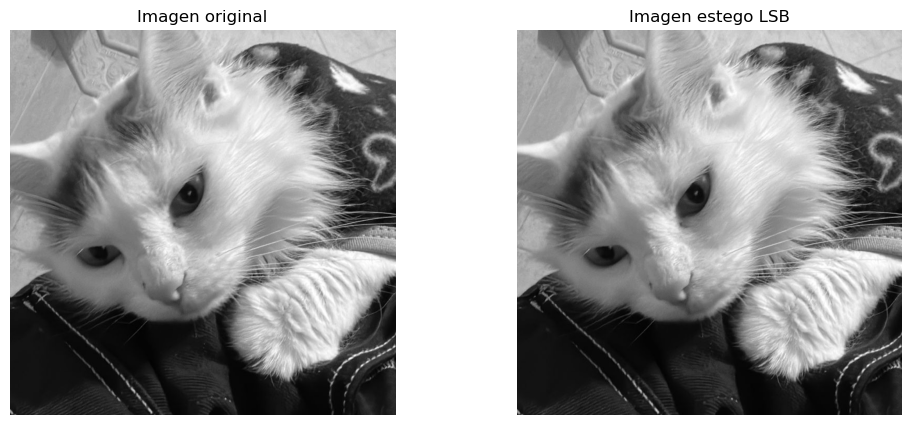

In [27]:
def texto_a_binario(msj):
    # mensaje -> ascii y ascii -> binario
    # fin de mensaje con &
    msj += '&'
    binario = ''
    
    # cada letra se pasa a ascii con ord() y luego a binario con format()
    for letra in msj:
        ascii = ord(letra)
        bin8 = format(ascii,'08b')
        # concateno resultado en array a retornar
        binario += bin8
        
    return binario

def LSB (host, msj):
    # flatten para recorrer la imagen como array (despues hacemos reshape)
    host = host.flatten()
    long_msj = len(msj)
    
    # si el mensaje entra en la imagen
    if (long_msj <= len(host)):
        for k in range(long_msj):
            val = host[k]
            
            # paso valor uint8 a bit
            val = bin(val)
            # val[:-1] me da todo el array excepto el último bit
            val_nuevo = val[:-1] + mensaje[k]
            host[k] = int(val_nuevo, 2)
            
    # si el mensaje es demasiado largo, informar
    else:
        print("El mensaje es demasiado largo")
        
    return host

msj = "YOU SHALL NOT PASS"
mensaje = texto_a_binario(msj)

# guardo el tamaño de la imagen para poder recuperarla después
x, y = img1.shape

img_LSB = LSB (img1,mensaje)
img_LSB = img_LSB.reshape((x,y))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img1, cmap = "gray")
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_LSB, cmap = "gray")
plt.title("Imagen estego LSB")
plt.axis('off')
plt.show()

# guardar como archivo estego > img_LSB es un array
img_guardar = Image.fromarray(img_LSB)
img_guardar.save("estego_ej1.png")

## DECODIFICADOR > EJERCICIO 1
1. Volcar la imagen en una matriz (matriz de bytes)
2. Pasar de matriz a array (array de bytes)
3. Recorro el array 

In [28]:
# DECODIFICADOR
def decodificar_mensaje(imagen):
    # como la imagen recibida es png, la cargo como matriz de bytes y la paso a array de bytes
    img = np.array(Image.open(imagen).convert('L'))
    img = img.flatten()
    
    msj_decodificado = ""
    k = 0
    fin = False

    while (not fin and k+8<=len(img)):
    # k va contando los bits que se leen. si a la img le quedan menos de 8, no los puede leer
        bits = ""
        for i in range(8):
            bits += str(img[k] & 1)
            k += 1
            
        # paso bits a byte, luego byte a char
        letra = chr(int(bits, 2))
        
        if letra == '&':
            fin = True
        else:
            msj_decodificado += letra
            
    return msj_decodificado

msg_oculto = decodificar_mensaje("estego_ej1.png")
print(f"Mensaje oculto: {msg_oculto}")

Mensaje oculto: YOU SHALL NOT PASS


# Ejercicio 2
Usar la TFT2 para ocultar una imagen, luego, decodificarla

1. Importar una imagen a ocultar (matriz de bytes con tamaño m,n)
2. Aplanar la matriz (array de bytes con tamaño m*n)
3. Pasar de bytes a bits (array de bits con tamaño 8*(m*n))
5. Aplicarle la transformada 2D de Fourier a imagen host
6. Aplicar flatten para transformarlo a un array. Cada elemento i tiene forma a+b.j
7. Si len(host) >= 8*len(img) entonces puedo esconder el mensaje
8. Hay que separar parte real de parte imaginaria para cada elemento i
9. Cambiar el signo de a y b por separado
10. Si bit_oc=0 y a<0 o si bit_oc=1 y a>0, -a
11. Si bit_oc=0 y b<0 o si bit_oc=1 y b>0, -b
12. Cuando terminé de ocultar el mensaje, obtengo array de reales e imaginarios
13. Regreso a matriz con reshape tamaño (x,y) (matriz de reales e imag)
14. Para visualizar la imagen, aplico inversa de la tft2

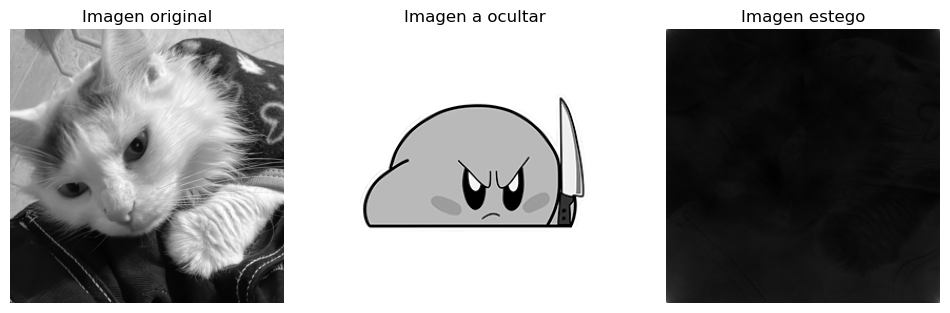

In [55]:
def bytes_a_bits (img):
    return np.unpackbits(img.astype(np.uint8)).astype(np.uint8)

def ocultar_img (host, tam_host, secreto, tam_secreto):
    # HOST: array de tamaño tam_host con componentes de fourier
    # SECRETO: array de tamaño tam_secreto con 1 o 0
    # indx itera dentro de host, cont cuenta bits del mensaje
    
    indx=0
    cont=0

    while (cont<tam_secreto and indx<tam_host):
        real = np.real(host[indx])
        imag = np.imag(host[indx])
        bit = secreto[cont]
        
        if ((bit==0 and real<0) or (bit==1 and real>0)):
            real=real*(-1)
            cont+=1
        else:
            cont+=1
            
        if (cont<tam_secreto):    
            if ((bit==0 and imag<0) or (bit==1 and imag>0)):
                imag=imag*(-1)
                cont+=1
            else: 
                cont+=1

        host[indx]=real+1j*imag
        indx+=1

    return host

def plotear (img1, img3, estego):
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img1, cmap="gray")
    plt.title("Imagen original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img3, cmap="gray")
    plt.title("Imagen a ocultar")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(estego, cmap="gray")
    plt.title("Imagen estego")
    plt.axis('off')

    plt.show()

# img1: imagen host 
# img3: matriz de bytes de 260x260
secreto = img3.copy()
secreto = secreto.flatten()

secreto = bytes_a_bits(secreto)
tam_secreto = len(secreto)

host_fft = fft2(img1)
host_fft = host_fft.flatten()
fft_tam = len(host_fft)

if (fft_tam >= tam_secreto):
    estego_tft = ocultar_img(host_fft, fft_tam, secreto, tam_secreto)
    estego_tft = estego_tft.reshape((x,y))
    estego = np.abs(ifft2(estego_tft))

    # guardar la imagen para después decodificar
    p = plt.imsave('estego_ej2.png', estego, cmap='gray')    
    plotear (img1, img3, estego)
else:
    "La imagen a ocultar es demasiado grande"

## DECODIFICADOR > EJERCICIO 2
1. Volcar la imagen en una matriz (matriz de bytes)
2. Guardo el tamaño de mi imagen en m, n
3. Aplico fft2 a la matriz (matriz de parte real e imag)
4. Pasar de matriz a array (array de parte real e imag)
5. Itero hasta array(len)
6. Separo parte real de imaginaria
7. Guardo el signo de a y de b en un array a retornar (array de 1 y 0)
8. Hago reshape al array retornado con tamaño (m, n)
 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



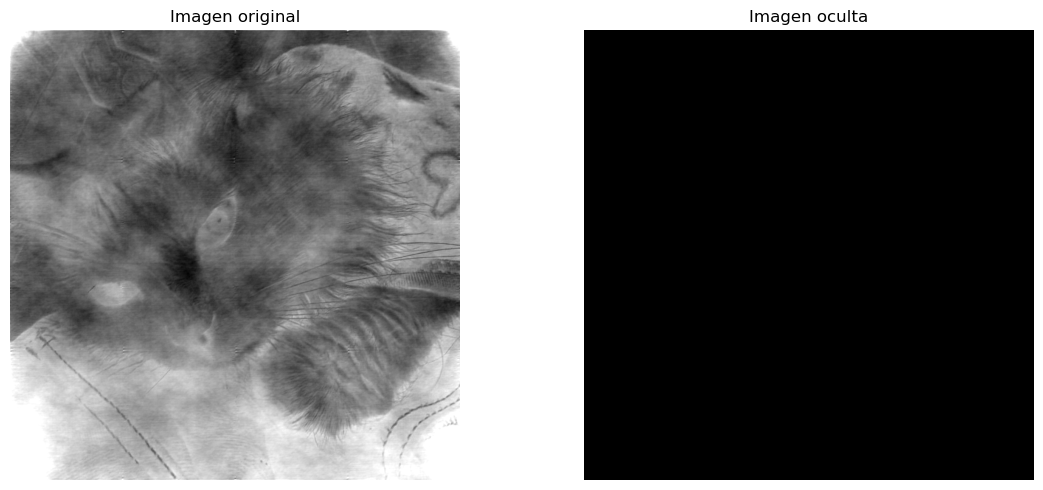

In [77]:
def decod_imagen (imagen):
    # como la imagen recibida es png, la cargo como matriz de bytes y la paso a array de bytes
    img = np.array(Image.open(imagen).convert('L'))

    img_decod = []
    img_f = fft2(img)
    img_f = img.flatten()
    tam = len(img_f)
    k=0

    while (k<tam):
        real = np.real(img_f[k])
        imag = np.imag(img_f[k])

        if (real>=0):
            img_decod.append(0)
        else:
            img_decod.append(1)

        if (imag>=0):
            img_decod.append(0)
        else:
            img_decod.append(1)
        
        k+=1

    img_decod = np.array(img_decod)
    img_decodif = np.packbits(img_decod)

    return img_decodif


es_ej2 = np.array(Image.open("estego_ej2.png").convert('L'))

# recibo array de bytes
este_2 = decod_imagen("estego_ej2.png")

m = int(np.sqrt(len(este_2)))

estego2 = este_2.reshape((m,m))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(es_ej2, cmap="gray")
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(estego2, cmap="gray")
plt.title("Imagen oculta")
plt.axis('off')

plt.tight_layout()
plt.show()
